In [10]:
from robobrowser import RoboBrowser
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from keras.models import model_from_json
from ztools.ntf import mail
import numpy as np
import statsmodels.api as sm
import time
import pickle
import json

In [11]:
from robobrowser import RoboBrowser
import time
import json

def turnFloat(x):
    x = x.replace('.', '').replace(',', '.')
    return float(x)

def into(item):
    return item[0]

def numerize(num):
    if str(num).lower() == 'nan':
        return 0
    else:
        return num
    
def turnCurrency(x):
    num = x.split('.')
    value = ''
    for i in range(1, len(num[0]) + 1):
        value = f'{num[0][-i]}{value}'
        if i % 3 == 0:
            value = f'.{value}'
    if len(num) > 1:
        value += f',{num[1][:3]}'
    else:
        value += ',000'
    return value
    
def today(nowtime):
    today = time.localtime(nowtime)
    day = str(today.tm_mday)
    if len(day) == 1:
        day = '0' + day
    mon = str(today.tm_mon)
    if len(mon) == 1:
        mon = '0' + mon
    year = str(today.tm_year)[-2:]
    date = f'{day}.{mon}.20{year}'
    return date

def now_value():
    browser = RoboBrowser(parser = 'html.parser')
    ticker = 'https://www.mercadobitcoin.net/api/BTC/ticker/'
    browser.open(ticker)
    r = json.loads(browser.response.content)
    date = time.localtime(r['ticker']['date'])
    value = turnCurrency(r['ticker']['last'])
    return (date, value)

In [12]:
data = pd.read_csv('btcbrl.csv')
hist = data[['Data', 'Último']][::-1]
hist.columns = ('date', 'val')
hist['val'] = list(map(turnFloat, hist['val']))
#hist.to_csv('data_brl.csv', index = False)

In [13]:
browser = RoboBrowser(parser = 'html.parser')
ticker = 'https://www.mercadobitcoin.net/api/BTC/ticker/'
browser.open(ticker)

In [14]:
r = json.loads(browser.response.content)
date = today(r['ticker']['date'])
value = r['ticker']['last']

In [15]:
browser = RoboBrowser(parser = 'html.parser', user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36')
url = 'https://br.investing.com/crypto/bitcoin/btc-brl-historical-data'
browser.open(url)

In [16]:
row = rows[1]
itens = row.find_all('td')
date = itens[0].text
val = turnFloat(itens[1].text)
fdate = pd.to_datetime(date)
d = ftoday - fdate

NameError: name 'rows' is not defined

In [ ]:
pin = 1066

In [23]:
df = pd.read_csv('data_brl.csv')
ftoday = pd.to_datetime(today(time.time()), dayfirst = True)
rows = browser.find(class_ = 'genTbl closedTbl historicalTbl').find_all('tr')[1:]
hist = {
    'date': [],
    'val': []
}
for row in rows:
    itens = row.find_all('td')
    date = itens[0].text
    val = turnFloat(itens[1].text)
    fdate = pd.to_datetime(date, dayfirst = True)
    if date not in df['date'].values:
        d = ftoday - fdate
        if d.days > 0 or (d.days == 0 and time.localtime().tm_hour >= 21):
            hist['date'].append(date)
            hist['val'].append(val)
hist['date'] = hist['date'][::-1]
hist['val'] = hist['val'][::-1]
df = pd.concat([df, pd.DataFrame(hist)], ignore_index = True)
df.to_csv('data_brl.csv', index = False)
df.tail()

,date,val
2479,27.03.2020,33102.8
2480,28.03.2020,32250.0
2481,29.03.2020,31095.0
2482,30.03.2020,33198.2
2483,31.03.2020,32769.0


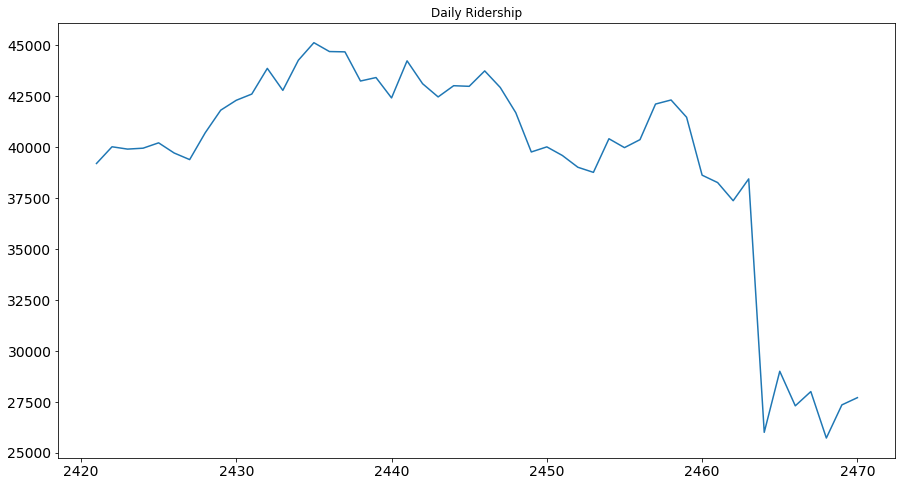

In [46]:
amost = 50
df[-amost:].val.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [47]:
d = 0
vals = df.val
last = vals.iloc[-(2+d)]
now = vals.iloc[-(1+d)]
var = round((now - last)/last, 4)
print(f'Variação: {var}')

Variação: 0.013


C:\Users\thale\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


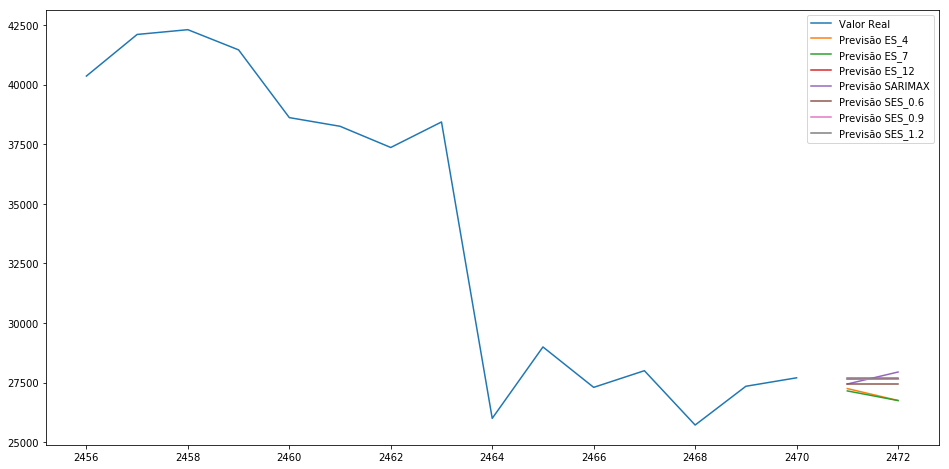

In [51]:
n_total = len(df)
amost = 15
n_pred = 2

pred = {}

null = np.array([None for _ in range(n_total)])

sp = 4
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.figure(figsize=(16,8))
plt.plot(df[-amost:]['val'], label = 'Valor Real')
plt.plot(pred[name], label = f'Previsão {name}')

sp = 7
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sp = 12
name = f'ES_{sp}'
fit1 = ExponentialSmoothing(np.asarray(df['val']) ,seasonal_periods=sp ,trend='add', seasonal='add',).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

name = f'SARIMAX'
fit1 = sm.tsa.statespace.SARIMAX(df['val'], order=(3, 1, 4),seasonal_order=(0,1,1,7)).fit()
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.6
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 0.9
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

sl = 1.2
name = f'SES_{sl}'
fit1 = SimpleExpSmoothing(np.asarray(df['val'])).fit(smoothing_level=sl,optimized=False)
forecast = fit1.forecast(n_pred)
pred[name] = np.concatenate((null, forecast))
plt.plot(pred[name], label = f'Previsão {name}')

#eps = 400
#name = f'Sequential_{eps}'
#model = Sequential()
#model.add(Dense(24, input_shape = (1,), activation='relu'))
#model.add(Dense(12, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#trainX, trainY = df['val'][:-1].values, df['val'][1:].values
#testX, testY = df['val'][-1:].values, df['val'].values
#model.fit(trainX, trainY, epochs=eps, batch_size=2, verbose=2)
#pred[name] = np.concatenate((null, model.predict(testX)[:,0]))
#plt.plot(pred[name], label = f'Previsão {name}')

plt.legend(loc='best')
plt.show()

In [52]:
hist = {
    'ES_4': [],
    'ES_7': [],
    'ES_12': [],
    'SARIMAX': [],
    'SES_0.6': [],
    'SES_0.9': [],
    'SES_1.2': [],
    'DP': [],
    'DP_U': [],
    'DP_D': [],
    'NUM_U': [],
    'NUM_D': [],
    'DIST_U': [],
    'DIST_D': [],
}

n = n_total
l = df['val'][n-1]

preds = []
ups = []
downs = []
print(f'Presente: {l}\n')

for k in pred.keys():
    p = pred[k][n]
    preds.append(p)
    up = (p > l)
    if up:
        ups.append(p)
        hist[k].append(1)
    else:
        downs.append(p)
        hist[k].append(0)
    print(f'{k}: {p} --- {up}')

sd = numerize(round(np.std(preds), 3))
u_sd = numerize(round(np.std(ups), 3))
d_sd = numerize(round(np.std(downs), 3))
u_len = numerize(round(len(ups), 3))
d_len = numerize(round(len(downs), 3))
u_dif = numerize(round(abs(np.mean(ups) - l), 3))
d_dif = numerize(round(abs(np.mean(downs) - l), 3))

hist['DP'].append(sd)
hist['DP_U'].append(u_sd)
hist['DP_D'].append(d_sd)
hist['NUM_U'].append(u_len)
hist['NUM_D'].append(d_len)
hist['DIST_U'].append(u_dif)
hist['DIST_D'].append(d_dif)

info = pd.DataFrame(hist)

print(f'\nDesvio Padrão: {sd}')
print(f'Desvio Padrão de crescentes: {u_sd}')
print(f'Desvio Padrão de decrescentes: {d_sd}')
print(f'Número de crescentes: {u_len}')
print(f'Número de decrescentes: {d_len}')
print(f'Distância de crescentes: {u_dif}')
print(f'Distância de decrescentes: {d_dif}')

Presente: 27700.4

ES_4: 27248.525995290373 --- False
ES_7: 27150.809332161632 --- False
ES_12: 27641.987198264025 --- False
SARIMAX: 27440.520864925475 --- False
SES_0.6: 27451.515785172676 --- False
SES_0.9: 27650.890088154665 --- False
SES_1.2: 27686.09879759245 --- False


C:\Users\thale\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\thale\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\thale\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\thale\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\thale\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Desvio Padrão: 193.128
Desvio Padrão de crescentes: 0
Desvio Padrão de decrescentes: 193.128
Número de crescentes: 0
Número de decrescentes: 7
Distância de crescentes: 0
Distância de decrescentes: 233.207


In [7]:
from ztools.ntf import mail, telegram


limit = 34100

#bot.send_message(my_id, f'Definido alerta sobre BTCBRL para limite de R$ {turnCurrency(str(limit))}.')

fvalue = float('inf')
last_value = fvalue
while True:
    try:
        data, cvalue = now_value()
        value = turnFloat(str(cvalue))
        if last_value < limit and value >= limit:
            print('Limite alcançado.')
            msg = f'O bitcoin está acima do limite definido.\n Valor atual: R$ {cvalue}.'
            #mail(sub = 'BTCBRL - Valor limite alcançado', msg = msg)
            telegram(msg = msg)
        elif last_value > limit and value <= limit:
            print('Limite perdido.')
            msg = f'O bitcoin está abaixo do limite definido.\n Valor atual: R$ {cvalue}.'
            #mail(sub = 'BTCBRL - Valor limite perdido', msg = msg)
            telegram(msg = msg)
        last_value = value
    except:
        pass
    time.sleep(30)

Limite perdido.
Limite alcançado.
Limite perdido.
Limite alcançado.
Limite perdido.
Limite alcançado.
Limite perdido.
Limite alcançado.
Limite perdido.
Limite alcançado.


KeyboardInterrupt: 